# Habitable Exoplanets
We're using the dataset of confirmed exoplanets from the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS&constraint=default_flag%20%3E0) to find potentially habitable exoplanets. Habitability in our case is only determined basically by the planet having a temperature where liquid water could exist on the surface. Column definitions are found [here](https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html).

## Data Exploration

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as stats

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

sns.set_theme(style="whitegrid")

In [3]:
planets = pd.read_csv('exoplanets.csv', header=98)
planets.head()

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-05-14,2008-01,2014-05-14
1,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-09-04,2017-03,2018-09-06
2,14 And b,14 And,1,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,-0.023,2.331,0.240,-0.240,4.91781,0.002826,-0.002826,2014-05-14,2008-12,2014-05-14
3,14 Her b,14 Her,1,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2022-09-19,2022-09,2022-09-19
4,16 Cyg B b,16 Cyg B,1,3,1,Radial Velocity,1996,Multiple Observatories,Published Confirmed,0,...,-0.016,4.651,0.016,-0.016,6.06428,0.000603,-0.000603,2018-09-04,2017-03,2018-09-06


[]

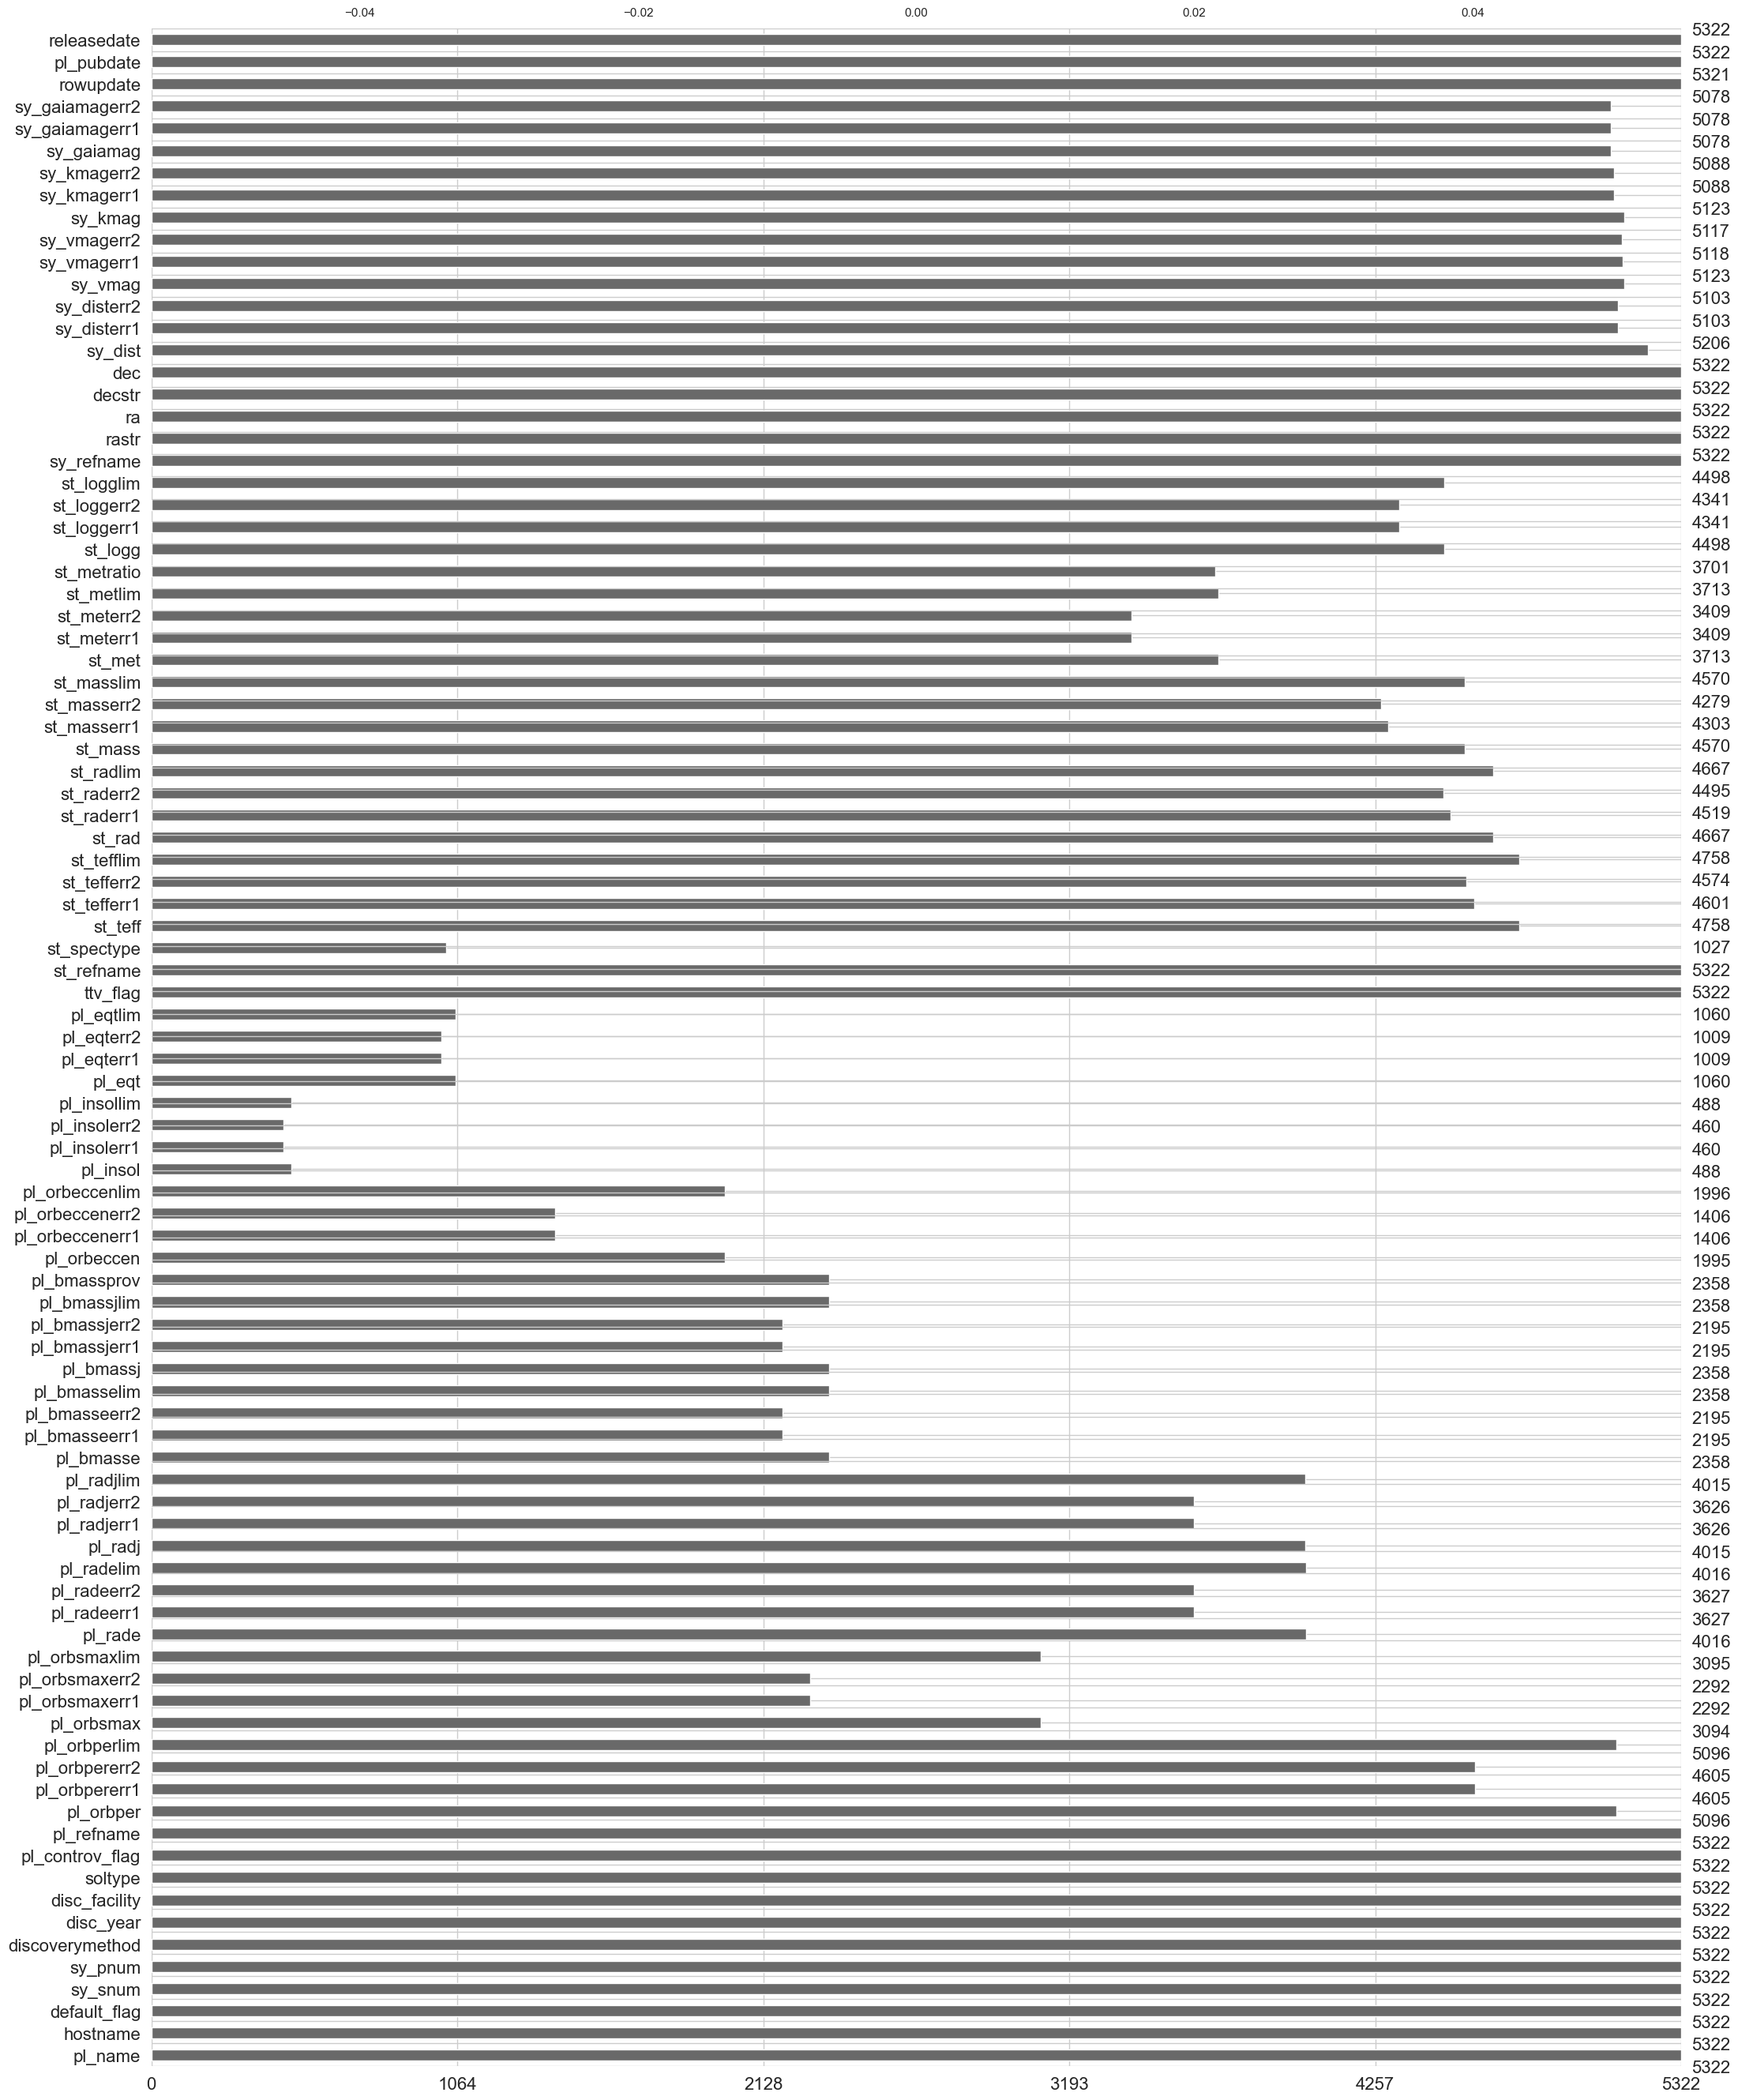

In [4]:
# look at missing data for each column
msno.bar(planets)
plt.plot()

In [5]:
# grab columns with most data / relevant data
hab_cols = ['pl_name', 'discoverymethod','pl_orbsmax','pl_eqt', 'pl_insol', 'pl_bmasse', 'pl_rade', 'pl_orbper', 
            'hostname', 'st_teff', 'st_rad', 'st_logg', 'st_met', 'st_mass', 'sy_pnum', 'sy_snum']
hab = planets[hab_cols]
hab.head()

,pl_name,discoverymethod,pl_orbsmax,pl_eqt,pl_insol,pl_bmasse,pl_rade,pl_orbper,hostname,st_teff,st_rad,st_logg,st_met,st_mass,sy_pnum,sy_snum
0,11 Com b,Radial Velocity,1.290000,NaN,NaN,6165.60000,NaN,326.030000,11 Com,4742.0,19.00,2.31,-0.35,2.70,1,2
1,11 UMi b,Radial Velocity,1.530000,NaN,NaN,4684.81420,NaN,516.219970,11 UMi,4213.0,29.79,1.93,-0.02,2.78,1,1
2,14 And b,Radial Velocity,0.830000,NaN,NaN,1525.50000,NaN,185.840000,14 And,4813.0,11.00,2.63,-0.24,2.20,1,1
3,14 Her b,Radial Velocity,2.773069,NaN,NaN,2586.74645,NaN,1765.038901,14 Her,NaN,NaN,NaN,NaN,0.91,2,1
4,16 Cyg B b,Radial Velocity,1.660000,NaN,NaN,565.73740,NaN,798.500000,16 Cyg B,5750.0,1.13,4.36,0.06,1.08,1,3


In [6]:
display(hab.isna().sum())
print("Total planets: ", len(hab))

pl_name               0
discoverymethod       0
pl_orbsmax         2228
pl_eqt             4262
pl_insol           4834
pl_bmasse          2964
pl_rade            1306
pl_orbper           226
hostname              0
st_teff             564
st_rad              655
st_logg             824
st_met             1609
st_mass             752
sy_pnum               0
sy_snum               0
dtype: int64

Total planets:  5322


In [34]:
# get number of rows with each type of discovery method
pd.DataFrame(hab['discoverymethod'].value_counts())

,count
discoverymethod,
Transit,3982
Radial Velocity,1032
Microlensing,181
Imaging,64
Transit Timing Variations,25
Eclipse Timing Variations,17
Orbital Brightness Modulation,9
Pulsar Timing,7
Astrometry,2


## Data Manipulation

In [8]:
# using the formula found here https://www.astro.princeton.edu/~strauss/FRS113/writeup3/
# takes into account the size and temperature of the star as well as how far away from the star the planet is
def calcTemp(st_temp, st_rad, sma):
    sunRadius = 695700
    st_rad = st_rad * sunRadius
    au = 1.5e8
    sma = sma * au
    albedo = 0.3
    pl_temp = st_temp * ((1-albedo)**0.25) * ((st_rad/(2*sma))**0.5)
    return pl_temp

In [9]:
# create calculated temperature column
hab['pl_calc_temp'] = calcTemp(hab['st_teff'], hab['st_rad'], hab['pl_orbsmax'])

/var/folders/zz/21vx7j397gl43mll8g08rc4r0000gn/T/ipykernel_5663/3932613760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hab['pl_calc_temp'] = calcTemp(hab['st_teff'], hab['st_rad'], hab['pl_orbsmax'])


In [10]:
# look at rows without missing values for pl_eqt and pl_calc_temp
hab[hab['pl_eqt'].notna() & hab['pl_calc_temp'].notna()].head()

# a bit different for pl_eqt and pl_calc_temp, maybe units are different?

,pl_name,discoverymethod,pl_orbsmax,pl_eqt,pl_insol,pl_bmasse,pl_rade,pl_orbper,hostname,st_teff,st_rad,st_logg,st_met,st_mass,sy_pnum,sy_snum,pl_calc_temp
11,2M0437 b,Imaging,118.0000,1450.0,NaN,1271.31363,NaN,NaN,2MASS J04372171+2651014,3100.0,0.84,4.50,0.01,0.17,1,1,11.520868
45,AF Lep b,Imaging,7.9900,1400.0,NaN,1664.46737,NaN,7.520000e+03,AF Lep,6100.0,1.25,4.40,NaN,1.20,1,1,106.276278
61,BD+60 1417 b,Imaging,1662.0000,1303.0,NaN,4767.42610,14.684,NaN,BD+60 1417,4993.0,0.80,4.55,NaN,1.00,1,1,4.825207
73,CD Cet b,Radial Velocity,0.0185,464.0,8.6,3.95000,NaN,2.290700e+00,CD Cet,3130.0,0.17,4.93,0.13,0.16,1,1,417.934110
75,CFHTWIR-Oph 98 b,Imaging,200.0000,1800.0,NaN,2479.06157,20.849,8.040000e+06,CFHTWIR-Oph 98 A,2320.0,0.24,3.85,NaN,0.01,1,1,3.540002


In [38]:
def calc_habitable(row):
    habitable_temp = 0
    habitable_insol = 0

    # check if pl_eqt is not missing and if in habitable range
    if (not np.isnan(row['pl_eqt'])):
        habitable_temp = ((row['pl_eqt'] > 180) & (row['pl_eqt'] < 310))

    # check if pl_insol is not missing and if in habitable range
    if (not np.isnan(row['pl_insol'])):
        habitable_insol = ((row['pl_insol'] > 0.25) & (row['pl_insol'] < 2.2))

    # if pl_eqt is missing, check if pl_calc_temp is in habitable range
    if (np.isnan(row['pl_eqt'])):
        habitable_temp = ((row['pl_calc_temp'] > 180) & (row['pl_calc_temp'] < 310))

    return habitable_temp | habitable_insol

In [14]:
# apply function to each row
hab['habitable'] = hab.apply(calc_habitable, axis=1)
hab['habitable'].sum()

/var/folders/zz/21vx7j397gl43mll8g08rc4r0000gn/T/ipykernel_5663/3336578937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hab['habitable'] = hab.apply(calc_habitable, axis=1)


190

In [15]:
# look at percentage of data missing for each column
hab_na_pct = hab.isna().sum() / len(hab)
hab_na_pct

pl_name            0.000000
discoverymethod    0.000000
pl_orbsmax         0.418640
pl_eqt             0.800827
pl_insol           0.908305
pl_bmasse          0.556933
pl_rade            0.245396
pl_orbper          0.042465
hostname           0.000000
st_teff            0.105975
st_rad             0.123074
st_logg            0.154829
st_met             0.302330
st_mass            0.141300
sy_pnum            0.000000
sy_snum            0.000000
pl_calc_temp       0.541526
habitable          0.000000
dtype: float64

In [16]:
# check how many rows are left when removing rows with missing values
hab.dropna().shape

# look at how many of those are habitable
hab.dropna()['habitable'].sum()


7

In [17]:
# save subset of data of columns with less than 90% missing values
hab_subset = hab.dropna(axis=1, thresh=len(hab) * 0.9)
display(hab_subset.columns)
hab_subset.dropna().shape

Index(['pl_name', 'discoverymethod', 'pl_orbper', 'hostname', 'sy_pnum',
       'sy_snum', 'habitable'],
      dtype='object')

(5096, 7)

In [18]:
# look at how many of those are habitable
hab_subset.dropna()['habitable'].sum()
# that is all the habitable included

190

## Classification

In [19]:
# instead, first pull out dataframe with only habitable exoplanets
hab_true = hab[hab['habitable'] == True]

# find which columns have less than 90% missing values
hab_true_na_pct = hab_true.isna().sum() / len(hab_true)

hab_true_subset = hab_true.dropna(axis=1, thresh=len(hab_true) * 0.9)
display(hab_true_subset.columns)
hab_true_subset.dropna().shape

Index(['pl_name', 'discoverymethod', 'pl_orbsmax', 'pl_orbper', 'hostname',
       'st_teff', 'st_rad', 'st_mass', 'sy_pnum', 'sy_snum', 'pl_calc_temp',
       'habitable'],
      dtype='object')

(175, 12)

In [20]:
# use these columns to subset the original dataframe, then build X and y data from that, then remove cols that don't make sense
hab_true_subset_cols = list(hab_true_subset.columns)

# keep habitable in so that indices match up for y, then remove useless columns and target variable
X = hab[hab_true_subset_cols].dropna()
y = X['habitable'].astype('int')

X = X.drop(columns=['habitable', 'pl_name', 'hostname', 'pl_calc_temp'])
X = pd.get_dummies(X, columns=['discoverymethod'], prefix='dm')

In [22]:
# use gridsearchcv to find best random forest classifier of habitable exoplanets
rfc = RandomForestClassifier()
param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8],
    'criterion' :['gini', 'entropy']
}

cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 7, n_jobs=-1)
cv_rfc.fit(X, y)
print("best model accuracy: ", cv_rfc.best_score_)
print("best model params: ", cv_rfc.best_params_)

best model accuracy:  0.9422558806655194
best model params:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}


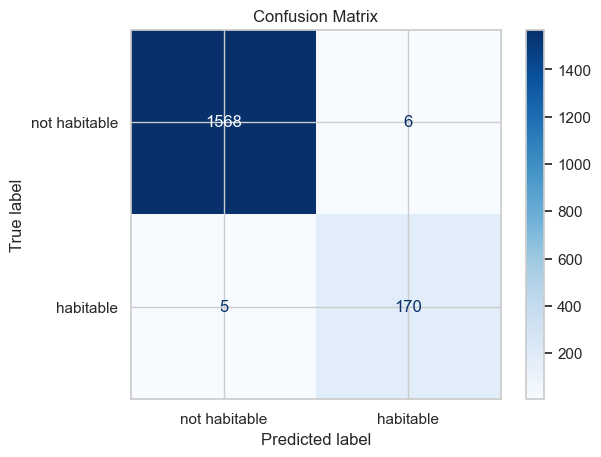

In [23]:
# look at confusion matrix for best model
y_pred = cv_rfc.predict(X)
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not habitable', 'habitable'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [24]:
# get the feature importances from best model and combine in df with the feature names
feature_importances = pd.DataFrame(cv_rfc.best_estimator_.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
pl_orbper,0.281004
pl_orbsmax,0.235045
st_rad,0.146937
st_teff,0.129663
st_mass,0.113897
dm_Transit,0.029469
dm_Radial Velocity,0.025836
sy_pnum,0.024648
sy_snum,0.008736
dm_Transit Timing Variations,0.003264


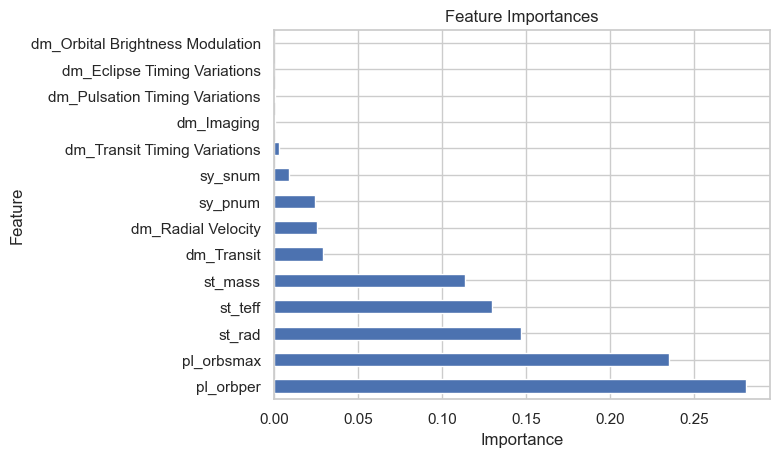

In [25]:
# plot the feature importances
feature_importances.plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.legend().remove()
plt.show()

In [26]:
# use the top 5 features and find best cv model
X_top5 = X[feature_importances.index[:5]]
cv_rfc_top5 = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 7, n_jobs=-1)
cv_rfc_top5.fit(X_top5, y)
print("best model accuracy: ", cv_rfc_top5.best_score_)
print("best model params: ", cv_rfc_top5.best_params_)

best model accuracy:  0.9605576592082615
best model params:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 500}


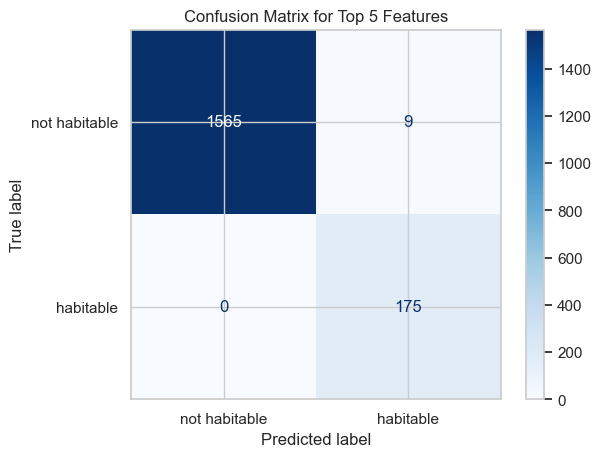

In [27]:
# look at confusion matrix for best model
y_pred_top5 = cv_rfc_top5.predict(X_top5)
cm_top5 = confusion_matrix(y, y_pred_top5)
disp_top5 = ConfusionMatrixDisplay(confusion_matrix=cm_top5, display_labels=['not habitable', 'habitable'], )
disp_top5.plot(cmap='Blues')
plt.title('Confusion Matrix for Top 5 Features')
plt.show()

In [28]:
# relook at what these features are and their importance in the new model
feature_importances_top5 = pd.DataFrame(cv_rfc_top5.best_estimator_.feature_importances_,
                                   index = X_top5.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances_top5

,importance
pl_orbper,0.321419
pl_orbsmax,0.243213
st_rad,0.188016
st_teff,0.134521
st_mass,0.112832


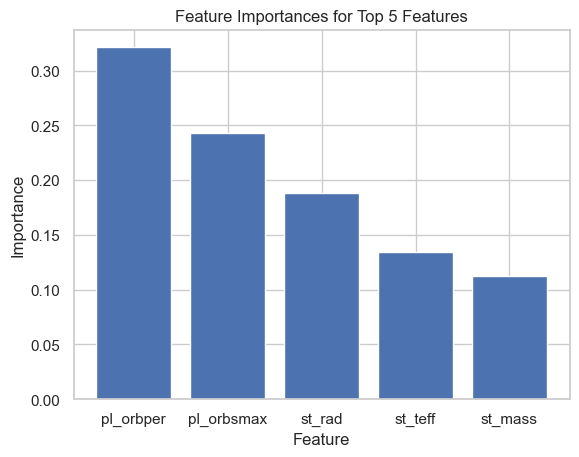

In [29]:
# plot feature importances
plt.bar(feature_importances_top5.index, feature_importances_top5['importance'])
plt.title('Feature Importances for Top 5 Features')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [30]:
# drop columns used to directly calculate temp
drop_cols = ['pl_orbsmax', 'st_rad', 'st_teff']
X_select = X.drop(columns=drop_cols)

# use gridsearchcv to find best random forest classifier of habitable exoplanets
rfc = RandomForestClassifier()
param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8]
}

cv_rfc_select = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 7, n_jobs=-1)
cv_rfc_select.fit(X_select, y)
print("best model accuracy: ", cv_rfc_select.best_score_)
print("best model params: ", cv_rfc_select.best_params_)

best model accuracy:  0.907956397016638
best model params:  {'max_depth': 8, 'max_features': 'log2', 'n_estimators': 500}


In [31]:
# look at feature importances
feature_importances_select = pd.DataFrame(cv_rfc_select.best_estimator_.feature_importances_,
                                   index = X_select.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances_select

,importance
pl_orbper,0.535499
st_mass,0.301322
sy_pnum,0.054317
dm_Transit,0.043256
dm_Radial Velocity,0.038553
sy_snum,0.017754
dm_Transit Timing Variations,0.006267
dm_Imaging,0.001726
dm_Pulsation Timing Variations,0.000705
dm_Eclipse Timing Variations,0.000386


In [32]:
# use basic logistic regression to see if it can beat the random forest classifier
logreg = LogisticRegression()

logreg_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

cv_logreg = GridSearchCV(estimator=logreg, param_grid=logreg_params, cv= 7, n_jobs=-1)
cv_logreg.fit(X_select, y)
print("best model accuracy: ", cv_logreg.best_score_)
print("best model params: ", cv_logreg.best_params_)

best model accuracy:  0.9005163511187607
best model params:  {'C': 100, 'penalty': 'l2'}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [33]:
# get most important features from logistic regression
feature_importances_logreg = pd.DataFrame(abs(cv_logreg.best_estimator_.coef_[0]),
                                   index = X_select.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances_logreg

,importance
dm_Transit,1.073542e+00
st_mass,8.596021e-01
sy_snum,5.659174e-01
dm_Radial Velocity,4.254145e-01
sy_pnum,1.199436e-01
dm_Transit Timing Variations,2.276683e-02
dm_Orbital Brightness Modulation,5.397990e-03
dm_Pulsation Timing Variations,2.333414e-03
dm_Imaging,1.808058e-03
dm_Eclipse Timing Variations,1.688168e-03


### Future Ideas
* Look at seeing if there are trends in stars that have habitable exoplanets to try and find stars to look for exoplanets
* try imputing data
* take out habitable exoplanets, compare stats to unhabitable exoplanets
* lots of plots and visualizations

## Comparing Habitable Exoplanets to Uninhabitable Exoplanets
Here we will dive into some of the different variables by splitting the groups between habitable and uninhabitable exoplanets

In [35]:
# get average distance of exoplanets from earth
planets.sy_dist.mean()

688.212414761045

In [39]:
# get a subset of the csv with all the data (none dropped yet) and sys_dist, calculate habitability again
planets_sub = planets[['pl_name', 'discoverymethod','pl_orbsmax','pl_eqt', 'pl_insol', 'pl_bmasse', 'pl_rade', 'pl_orbper', 
            'hostname', 'st_teff', 'st_rad', 'st_logg', 'st_met', 'st_mass', 'sy_pnum', 'sy_snum', 'sy_dist']]

planets_sub['pl_calc_temp'] = calcTemp(planets_sub['st_teff'], planets_sub['st_rad'], planets_sub['pl_orbsmax'])

planets_sub['habitable'] = planets_sub.apply(calc_habitable, axis=1)
planets_sub.habitable.sum()

/var/folders/zz/21vx7j397gl43mll8g08rc4r0000gn/T/ipykernel_5663/52079584.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  planets_sub['pl_calc_temp'] = calcTemp(planets_sub['st_teff'], planets_sub['st_rad'], planets_sub['pl_orbsmax'])
/var/folders/zz/21vx7j397gl43mll8g08rc4r0000gn/T/ipykernel_5663/52079584.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  planets_sub['habitable'] = planets_sub.apply(calc_habitable, axis=1)


190

In [41]:
# perform a t test comparing sy_dist between habitable and non habitable exoplanets
habitable = planets_sub[planets_sub['habitable'] == 1]
non_habitable = planets_sub[planets_sub['habitable'] == 0]

stats.ttest_ind(habitable['sy_dist'], non_habitable['sy_dist'], nan_policy='omit')

Ttest_indResult(statistic=-6.667331611218373, pvalue=2.8749183835060042e-11)

In [46]:
# look at difference in the mean sys_dist between habitable and non habitable exoplanets
print("Habitable mean sys_dist: ", habitable['sy_dist'].mean())
print("Non habitable mean sys_dist: ", non_habitable['sy_dist'].mean())

Habitable mean sys_dist:  174.14300840782118
Non habitable mean sys_dist:  706.5172533799483


<Axes: xlabel='pl_orbsmax', ylabel='pl_calc_temp'>

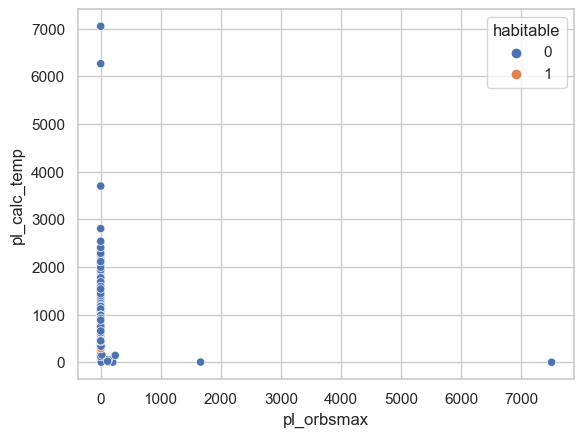

In [51]:
# plot pl_orbsmax vs pl_calc_temp, color by habitable
sns.scatterplot(data=planets_sub, x='pl_orbsmax', y='pl_calc_temp', hue='habitable')

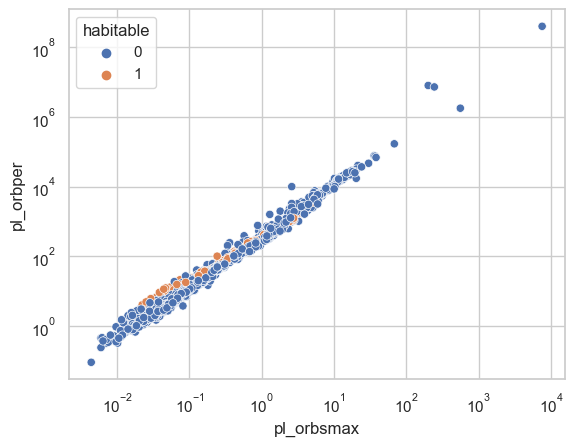

In [54]:
# redo the scatterplot but with variables on a log scale to better show the data
sns.scatterplot(data=planets_sub, x='pl_orbsmax', y='pl_orbper', hue='habitable')
plt.xscale('log')
plt.yscale('log')
plt.show()

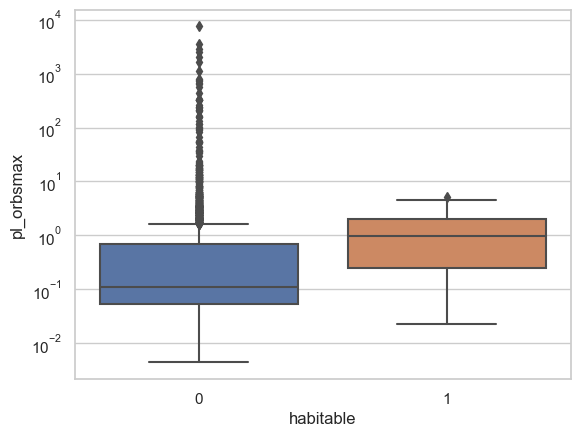

In [60]:
# plot boxplots of pl_orbsmax and pl_orbper, color by habitable
sns.boxplot(data=planets_sub, x='habitable', y='pl_orbsmax')
plt.yscale('log')
plt.show()

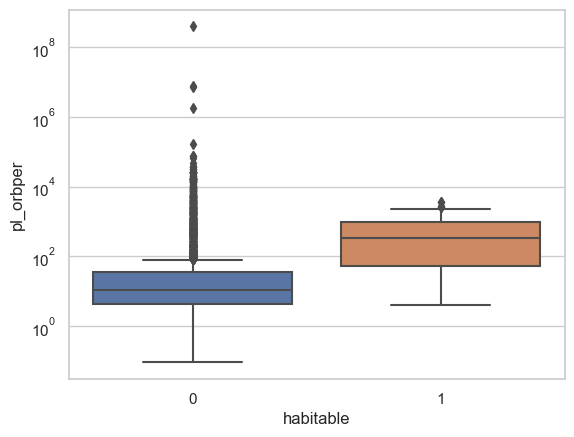

In [61]:
# plot boxplots for orbital period
sns.boxplot(data=planets_sub, x='habitable', y='pl_orbper')
plt.yscale('log')
plt.show()